In [1]:
%jars ABAGAIL.jar
%jars ProjectHelpers.jar
%jars xchart-3.6.5.jar

import java.io.FileReader;
import java.io.File;
import java.lang.String;
import java.lang.StringBuffer;
import java.lang.Boolean;
import java.util.Random;
import dist.DiscreteDependencyTree;
import dist.DiscreteUniformDistribution;
import dist.Distribution;
import opt.DiscreteChangeOneNeighbor;
import opt.EvaluationFunction;
import opt.GenericHillClimbingProblem;
import opt.HillClimbingProblem;
import opt.NeighborFunction;
import opt.RandomizedHillClimbing;
import opt.SimulatedAnnealing;
import opt.ga.*;
import opt.prob.GenericProbabilisticOptimizationProblem;
import opt.prob.MIMIC;
import opt.prob.ProbabilisticOptimizationProblem;
import shared.FixedIterationTrainer;
import opt.example.ContinuousPeaksEvaluationFunction;
import helpers.ProjectTrainer;
import org.knowm.xchart.*;
import opt.prob.MIMIC;
import  org.knowm.xchart.style.markers.*;

In [2]:
int[] Ns = new int[] {40, 60, 80, 100, 200, 300 };
int folds = 10;
int iterations = 200000;
var gridSearch = false;

# 1. RHC

### 1.1 Experiment

In [3]:
RandomizedHillClimbing rhc;
ArrayList<ProjectTrainer> rhcFits = new ArrayList<ProjectTrainer>();

double[] rhcScores = new double[Ns.length];
double[] rhcDurationsMS = new double[Ns.length];
double[] rhcBestIterations = new double[Ns.length];

double[] fitCurveIterations = null;
double[] fitCurveScores = null;

for(int i = 0; i < Ns.length; i++) {
    int N = Ns[i];
    int[] ranges = new int[N];
    Arrays.fill(ranges, 2);
    int T = N/10;
    
    var ef = new ContinuousPeaksEvaluationFunction(T);
    var odd = new DiscreteUniformDistribution(ranges);
    var nf = new DiscreteChangeOneNeighbor(ranges);
    
    double scoreTotal = 0;
    double iterationsBestTotal = 0;
    double durationsMSTotal = 0;
    double iterationsTotal;
    
    var recordFitnessCurve = i == Ns.length - 1;
    for(int fold = 0; fold < folds; fold++){      
        var hcp = new GenericHillClimbingProblem(ef, odd, nf);

        rhc = new RandomizedHillClimbing(hcp);

        var fit = new ProjectTrainer(rhc, iterations);
        rhcFits.add(fit);

        fit.train();
        
        scoreTotal += ef.value(rhc.getOptimal());
        iterationsBestTotal += fit.getBestIterations();
        durationsMSTotal += fit.getDuration().toMillis();
        
        if(recordFitnessCurve && fitCurveIterations == null){
            fitCurveIterations = fit.history.iterations;
            fitCurveScores = fit.history.scores;
        }
        else if(recordFitnessCurve) {
            for(int j = 0; j < fit.history.scores.length; j++){
                double s = fit.history.scores[j];
                fitCurveScores[j] =  (s + fold * fitCurveScores[j])/(fold+1);
            }
        }
    }
    double durationMs = durationsMSTotal/folds;
    double score = scoreTotal/folds;
    double iterationsBest = iterationsBestTotal/folds;
    
    rhcScores[i] = score;
    rhcDurationsMS[i] = durationMs;
    rhcBestIterations[i] = iterationsBest;
}

double[] RHCfitCurveIterations = fitCurveIterations;
double[] RHCfitCurveScores = fitCurveScores;

# 2. Simulated Annealing

### 2.1 Gridsearch for best params

In [4]:
double[] SACooling = new double[] {0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.5};
var SAbestParams = new HashMap<String, Double>();
SAbestParams.put("cooling", 0.95);

In [5]:
if(gridSearch){    
    double bestScore = -1;
    
    for(var cool : SACooling){
        double avgOfAllScores = 0.0;
        int N = 300;
        int[] ranges = new int[N];
        Arrays.fill(ranges, 2);
        int T = N/10;
        var ef = new ContinuousPeaksEvaluationFunction(T);
        var odd = new DiscreteUniformDistribution(ranges);
        var nf = new DiscreteChangeOneNeighbor(ranges);

        double scoreTotal = 0;
        double iterationsBestTotal = 0;
        double durationsMSTotal = 0;
        double iterationsTotal;
        for(int fold = 0; fold < folds; fold++){    
            var hcp = new GenericHillClimbingProblem(ef, odd, nf);
            var sa = new SimulatedAnnealing(1e11, cool, hcp);
            var fit = new ProjectTrainer(sa, iterations);
            fit.train();

            scoreTotal += ef.value(sa.getOptimal());
            iterationsBestTotal += fit.getBestIterations();
            durationsMSTotal += fit.getDuration().toMillis();
        }
        //double durationMs = durationsMSTotal/folds;
        double score = scoreTotal/folds;
        //double iterationsBest = iterationsBestTotal/folds;
        double avgOfScores = avgOfAllScores/1;
        if(score > bestScore){
            bestScore = score;
            SAbestParams = new HashMap<String, Double>();
            SAbestParams.put("cooling", cool);
        }
    }
}


In [6]:
SAbestParams

{cooling=0.95}

### 2.2 Experiment

In [7]:
double[] SAscores = new double[Ns.length];
double[] SAdurationsMS = new double[Ns.length];
double[] SAbestIterations = new double[Ns.length];

double[] fitCurveIterations = null;
double[] fitCurveScores = null;
var cool = SAbestParams.get("cooling");
for(int i = 0; i < Ns.length; i++) {
    int N = Ns[i];
    double scoreSum = 0;
    double durationMsSum = 0;
    double bestIterationSum = -1;
    
    int[] ranges = new int[N];
    Arrays.fill(ranges, 2);
    int T = N/10;
    var ef = new ContinuousPeaksEvaluationFunction(T);
    var odd = new DiscreteUniformDistribution(ranges);
    var nf = new DiscreteChangeOneNeighbor(ranges);
    
    var recordFitnessCurve = i == (Ns.length - 1);

    for(int fold = 0; fold < folds; fold++){
        var hcp = new GenericHillClimbingProblem(ef, odd, nf);
        var sa = new SimulatedAnnealing(1e11, cool, hcp);
        var fit = new ProjectTrainer(sa, iterations);
        fit.train();
        
        scoreSum += ef.value(sa.getOptimal());
        durationMsSum += fit.getDuration().toMillis();
        bestIterationSum += fit.getBestIterations();
        
        if(recordFitnessCurve && fitCurveIterations == null){
            fitCurveIterations = fit.history.iterations;
            fitCurveScores = fit.history.scores;
        }
        else if(recordFitnessCurve) {
            for(int j = 0; j < fit.history.scores.length; j++){
                double s = fit.history.scores[j];
                fitCurveScores[j] =  (s + fold * fitCurveScores[j])/(fold+1);
            }
        }
    }
    
    var score = scoreSum/folds; 
    SAscores[i] = score;
    var durationMs = durationMsSum/folds; 
    SAdurationsMS[i] = durationMs;
    var bestIteration = bestIterationSum/folds; 
    SAbestIterations[i] = bestIteration;
}

var SAfitCurveIterations = fitCurveIterations;
var SAfitCurveScores = fitCurveScores;

# 3. Genetic Algorithm

In [8]:
int N = 100;
int[] ranges = new int[N];
Arrays.fill(ranges, 2);
int T = N/10;

In [9]:
double[] GAPopulationMultiplier = new double[] { 0.25, 0.5, 1.0, 2.0 };
double[] GAMutateMultiplier = new double[] { 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0 };
CrossoverFunction[] crossOvers = new CrossoverFunction[] {
    new SingleCrossOver(),
    new TwoPointCrossOver(),
    new UniformCrossOver()
};

In [10]:
ArrayList<HashMap<String, Object>> allParams = new ArrayList<HashMap<String, Object>>();
for(Double popMultiplier : GAPopulationMultiplier){
    for(Double mutateMultiplier : GAMutateMultiplier){
        for(CrossoverFunction cf : crossOvers){
            var p = new HashMap<String, Object>();
            p.put("pop", popMultiplier);
            p.put("mut", mutateMultiplier);
            p.put("cf", cf);
            allParams.add(p);
        }
    }
}

### 3.1 Grid Search

In [11]:
//{pop=2.0, cf=opt.ga.TwoPointCrossOver@3245c208, mut=0.5}
var bestParams = new HashMap<String, Object>();
bestParams.put("pop", 2.0);
bestParams.put("mut", 0.5);
bestParams.put("cf", new TwoPointCrossOver());

In [12]:
int N = 100;
int count = 0;
double bestScore = -1;
if(gridSearch){
    for(var params : allParams){
        count += 1;
        if((count % (allParams.size()/10)) == 0){
            System.out.printf("%2.0f%%\n",100*(double)count/allParams.size());
        }
        int[] ranges = new int[N];
        Arrays.fill(ranges, 2);
        int T = N/10;
        var ef = new ContinuousPeaksEvaluationFunction(T);
        var odd = new DiscreteUniformDistribution(ranges);
        var mf = new DiscreteChangeOneMutation(ranges);

        var pop = (double)params.get("pop");
        var mut = (double)params.get("mut");
        var cf = (CrossoverFunction)params.get("cf");

        double scoreSum = 0;
        double durationMsSum = 0;
        double bestIterationSum = -1;

        for(var k = 0; k < folds; k++){
            var gap = new GenericGeneticAlgorithmProblem(ef, odd, mf, cf);
            var ga = new StandardGeneticAlgorithm((int)(pop*N), (int)(pop*N/2), (int)(mut*N), gap);

            var fit = new ProjectTrainer(ga, iterations/100); // Use 1000 instead of 200,000
            fit.train();

            scoreSum += ef.value(ga.getOptimal());
            durationMsSum += fit.getDuration().toMillis();
            bestIterationSum += fit.getBestIterations();
        }

        double score = scoreSum/folds;
        if(score > bestScore){
            bestScore = score;
            bestParams = params;
        }
    }
}
var GABestParams = bestParams

In [13]:
GABestParams //{pop=2.0, cf=opt.ga.TwoPointCrossOver@3245c208, mut=0.5}

{pop=2.0, cf=opt.ga.TwoPointCrossOver@6a4e0d50, mut=0.5}

In [14]:
// delete me if you dont want to skip grid search

var GABestParams = new HashMap<String, Object>();
GABestParams.put("pop", 2.0);
GABestParams.put("cf", new TwoPointCrossOver());
GABestParams.put("mut", 0.5);


### 3.2 Experiment

In [15]:
double[] GAscores = new double[Ns.length];
double[] GAdurationsMS = new double[Ns.length];
double[] GAbestIterations = new double[Ns.length];

int count = 0;
double[] fitCurveIterations = null;
double[] fitCurveScores = null;
for(int i = 0; i < Ns.length; i++) {    
    int N = Ns[i];
    double scoreSum = 0;
    double durationMsSum = 0;
    double bestIterationSum = -1;
    
    int[] ranges = new int[N];
    Arrays.fill(ranges, 2);
    int T = N/10;
    var ef = new ContinuousPeaksEvaluationFunction(T);
    var odd = new DiscreteUniformDistribution(ranges);
    var mf = new DiscreteChangeOneMutation(ranges);
    
    var pop = (double)GABestParams.get("pop");
    var mut = (double)GABestParams.get("mut");
    var cf = (CrossoverFunction)GABestParams.get("cf");
    
    var recordFitnessCurve = i == (Ns.length - 1);
    for(int fold = 0; fold < folds; fold++){
        var gap = new GenericGeneticAlgorithmProblem(ef, odd, mf, cf);
        var ga = new StandardGeneticAlgorithm((int)(pop*N), (int)(pop*N/2), (int)(mut*N), gap);
        var fit = new ProjectTrainer(ga, iterations/100);  // Use 2000 instead of 200,000
        fit.train();
        
        scoreSum += ef.value(ga.getOptimal());
        durationMsSum += fit.getDuration().toMillis();
        bestIterationSum += fit.getBestIterations();
        
        if(recordFitnessCurve && fitCurveIterations == null){
            fitCurveIterations = fit.history.iterations;
            fitCurveScores = fit.history.scores;
        }
        else if(recordFitnessCurve) {
            for(int j = 0; j < fit.history.scores.length; j++){
                double s = fit.history.scores[j];
                fitCurveScores[j] =  (s + fold * fitCurveScores[j])/(fold+1);
            }
        }
    }
    
    var score = scoreSum/folds; 
    GAscores[i] = score;
    var durationMs = durationMsSum/folds; 
    GAdurationsMS[i] = durationMs;
    var bestIteration = bestIterationSum/folds; 
    GAbestIterations[i] = bestIteration;
}

var GAfitCurveIterations = fitCurveIterations;
var GAfitCurveScores = fitCurveScores;

# 4. MIMIC

In [16]:
int[] MimicSamples = new int[] { 40, 80, 120, 160, 200 };
double[] MimicSamplesKeptMultiplier = new double[] { 0.1, 0.2, 0.3, 0.4, 0.5};

In [17]:
ArrayList<HashMap<String, Object>> allParams = new ArrayList<HashMap<String, Object>>();
for(Integer samples : MimicSamples){
    for(Double samplesKept : MimicSamplesKeptMultiplier){
        var p = new HashMap<String, Object>();
        p.put("samples", samples);
        p.put("kept", samplesKept);
        allParams.add(p);
    }
}

### 4.1 Grid Search

In [18]:
//{kept=0.1, samples=80}
var bestParams = new HashMap<String, Object>();
bestParams.put("samples", 80);
bestParams.put("kept", 0.1);

In [19]:
N = 100;
int count = 0;
double bestScore = -1;
if(gridSearch){
    for(var params : allParams){
        count += 1;
        if((count % (allParams.size()/10)) == 0){
            System.out.printf("%2.0f%%\n",100*(double)count/allParams.size());
        }

        int[] ranges = new int[N];
        Arrays.fill(ranges, 2);
        int T = N/10;

        var ef = new ContinuousPeaksEvaluationFunction(T);

        var odd = new DiscreteUniformDistribution(ranges);
        var df = new DiscreteDependencyTree(.1, ranges);

        double scoreSum = 0;
        double durationMsSum = 0;
        double bestIterationSum = -1;


        var samples = (int)(params.get("samples"));
        var samplesKeptMultiplier = (double)params.get("kept");

        for(var k = 0; k < folds; k++){
            var pop = new GenericProbabilisticOptimizationProblem(ef, odd, df);

            var mimic = new MIMIC(samples, (int)(samplesKeptMultiplier*samples), pop);

            var fit = new ProjectTrainer(mimic, iterations/100); // Use 2000 instead of 200,000
            fit.train();

            scoreSum += ef.value(mimic.getOptimal());
            durationMsSum += fit.getDuration().toMillis();
            bestIterationSum += fit.getBestIterations();
        }

        double score = scoreSum/folds;
        if(score > bestScore){
            bestScore = score;
            bestParams = params;
        }
    }
}
var mimicBestParams = bestParams

In [20]:
mimicBestParams

{kept=0.1, samples=80}

### 4.2 Experiment

In [21]:
double[] mimicScores = new double[Ns.length];
double[] mimicDurationsMS = new double[Ns.length];
double[] mimicBestIterations = new double[Ns.length];

int count = 0;
double[] fitCurveIterations = null;
double[] fitCurveScores = null;
for(int i = 0; i < Ns.length; i++) {    
    int N = Ns[i];
    int[] ranges = new int[N];
    Arrays.fill(ranges, 2);
    int T = N/10;
    
    var ef = new ContinuousPeaksEvaluationFunction(T);    
    var odd = new DiscreteUniformDistribution(ranges);
    var df = new DiscreteDependencyTree(.1, ranges);
    
    double scoreSum = 0;
    double durationMsSum = 0;
    double bestIterationSum = -1;
    
    
    var samples = (int)(mimicBestParams.get("samples"));
    var samplesKeptMultiplier = (double)mimicBestParams.get("kept");
    
    var recordFitnessCurve = i == (Ns.length - 1);
    for(int fold = 0; fold < folds; fold++){
        var pop = new GenericProbabilisticOptimizationProblem(ef, odd, df);
        
        var mimic = new MIMIC(samples, (int)(samplesKeptMultiplier*samples), pop);
        
        var fit = new ProjectTrainer(mimic, iterations/100); // Use 2000 instead of 200,000
        fit.train();
        
        scoreSum += ef.value(mimic.getOptimal());
        durationMsSum += fit.getDuration().toMillis();
        bestIterationSum += fit.getBestIterations();
        if(recordFitnessCurve && fitCurveIterations == null){
            fitCurveIterations = fit.history.iterations;
            fitCurveScores = fit.history.scores;
        }
        else if(recordFitnessCurve) {
            for(int j = 0; j < fit.history.scores.length; j++){
                double s = fit.history.scores[j];
                fitCurveScores[j] =  (s + fold * fitCurveScores[j])/(fold+1);
            }
        }
    }
    
    var score = scoreSum/folds; 
    mimicScores[i] = score;
    var durationMs = durationMsSum/folds; 
    mimicDurationsMS[i] = durationMs;
    var bestIteration = bestIterationSum/folds; 
    mimicBestIterations[i] = bestIteration;
}
var mimicfitCurveIterations = fitCurveIterations;
var mimicfitCurveScores = fitCurveScores;

In [22]:
System.out.println("Mimic");
for(var score : mimicScores){
    System.out.println(score);
}
System.out.println("-----");
System.out.println("GA");
for(var score : GAscores){
    System.out.println(score);
}

System.out.println("-----");
System.out.println("SA");
for(var score : SAscores){
    System.out.println(score);
}

System.out.println("-----");
System.out.println("RHC");
for(var score : rhcScores){
    System.out.println(score);
}

Mimic
75.0
112.4
148.1
176.0
145.5
159.1
-----
GA
67.1
96.7
124.0
142.5
192.4
126.7
-----
SA
71.5
113.0
143.9
171.2
200.0
300.0
-----
RHC
64.5
77.6
93.8
103.6
200.0
300.0


# Charts

In [23]:
double[] Ns_double = new double[Ns.length];
for(int i = 0; i<Ns.length; i++){
    Ns_double[i] = Ns[i];
}

### 1. Problem Size vs Average Score

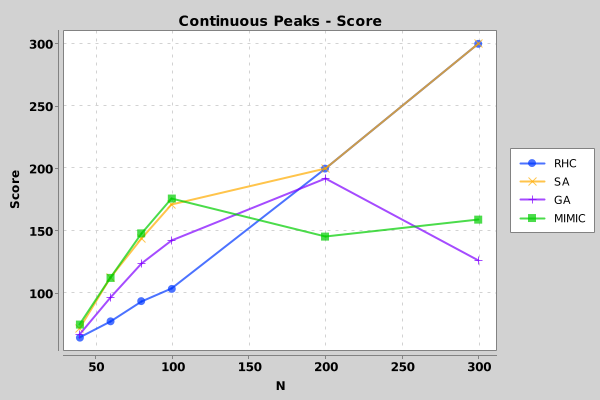

In [43]:
List<org.knowm.xchart.internal.chartpart.Chart> charts = new ArrayList<org.knowm.xchart.internal.chartpart.Chart>();

// Score
var chart = new XYChartBuilder()
    .xAxisTitle("N").yAxisTitle("Score").width(600).height(400).title("Continuous Peaks - Score").build();

var s1 = chart.addSeries("RHC", Ns_double, rhcScores);
s1.setMarker(SeriesMarkers.CIRCLE);

var s2 = chart.addSeries("SA", Ns_double, SAscores);
s2.setMarker(SeriesMarkers.CROSS);

var s3 = chart.addSeries("GA", Ns_double, GAscores);
s3.setMarker(SeriesMarkers.PLUS);

var s4 = chart.addSeries("MIMIC", Ns_double, mimicScores);
s4.setMarker(SeriesMarkers.SQUARE);

charts.add(chart);
var score = chart;

BitmapEncoder.getBufferedImage(chart);

### 2. Problem Size vs Average Optimization Time

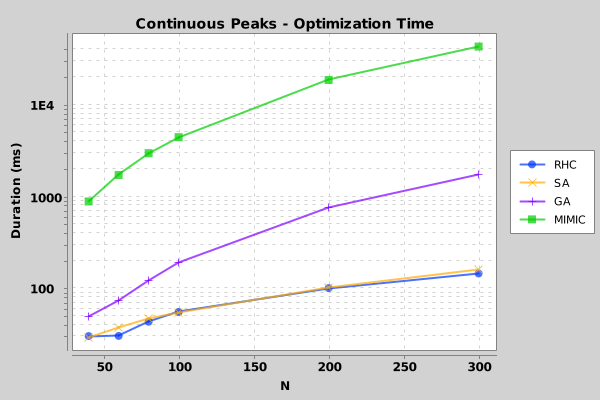

In [44]:
// Optimization Time
var chart = new XYChartBuilder()
    .xAxisTitle("N").yAxisTitle("Duration (ms)").width(600).height(400).title("Continuous Peaks - Optimization Time").build();
chart.getStyler().setYAxisLogarithmic(true);
var s1 = chart.addSeries("RHC", Ns_double, rhcDurationsMS);
s1.setMarker(SeriesMarkers.CIRCLE);

var s2 = chart.addSeries("SA", Ns_double, SAdurationsMS);
s2.setMarker(SeriesMarkers.CROSS);

var s3 = chart.addSeries("GA", Ns_double, GAdurationsMS);
s3.setMarker(SeriesMarkers.PLUS);

var s4 = chart.addSeries("MIMIC", Ns_double, mimicDurationsMS);
s4.setMarker(SeriesMarkers.SQUARE);

charts.add(chart);
var duration = chart;

BitmapEncoder.getBufferedImage(chart);

### 3.0 Problem Size vs Average EF calls to max

How many times the EF was called before we reached max, averaged over all folds

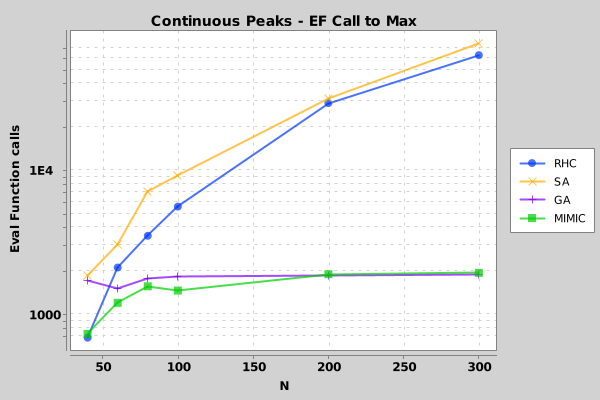

In [45]:
// EF evals to Maximize
var chart = new XYChartBuilder()
    .xAxisTitle("N").yAxisTitle("Eval Function calls").width(600).height(400).title("Continuous Peaks - EF Call to Max").build();
chart.getStyler().setYAxisLogarithmic(true);
var s1 = chart.addSeries("RHC", Ns_double, rhcBestIterations);
s1.setMarker(SeriesMarkers.CIRCLE);

var s2 = chart.addSeries("SA", Ns_double, SAbestIterations);
s2.setMarker(SeriesMarkers.CROSS);

var s3 = chart.addSeries("GA", Ns_double, GAbestIterations);
s3.setMarker(SeriesMarkers.PLUS);

var s4 = chart.addSeries("MIMIC", Ns_double, mimicBestIterations);
s4.setMarker(SeriesMarkers.SQUARE);

charts.add(chart);
var duration = chart;

BitmapEncoder.getBufferedImage(chart);

### 4.0 Iterations vs Score

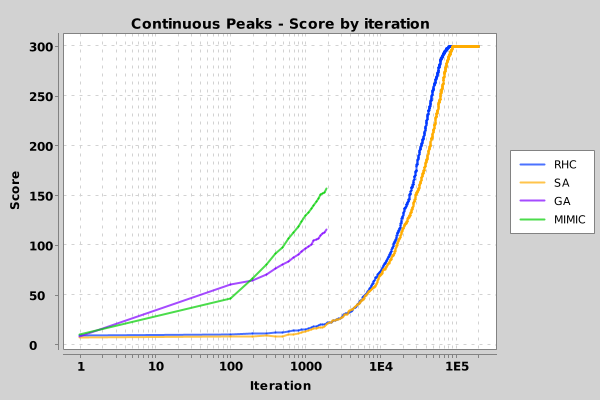

In [46]:
var chart = new XYChartBuilder()
    .xAxisTitle("Iteration").yAxisTitle("Score").width(600).height(400)
    .title("Continuous Peaks - Score by iteration").build();
chart.getStyler().setXAxisLogarithmic(true);

var s1 = chart.addSeries("RHC", RHCfitCurveIterations, RHCfitCurveScores);
//s1.setMarker(SeriesMarkers.CIRCLE);
s1.setMarker(SeriesMarkers.NONE);

var s2 = chart.addSeries("SA", SAfitCurveIterations, SAfitCurveScores);
//s2.setMarker(SeriesMarkers.CROSS);
s2.setMarker(SeriesMarkers.NONE);

var s3 = chart.addSeries("GA", GAfitCurveIterations, GAfitCurveScores);
s3.setMarker(SeriesMarkers.NONE);

var s4 = chart.addSeries("MIMIC", mimicfitCurveIterations, mimicfitCurveScores);
s4.setMarker(SeriesMarkers.NONE);

charts.add(chart);

var duration = chart;

BitmapEncoder.getBufferedImage(charts.get(3));

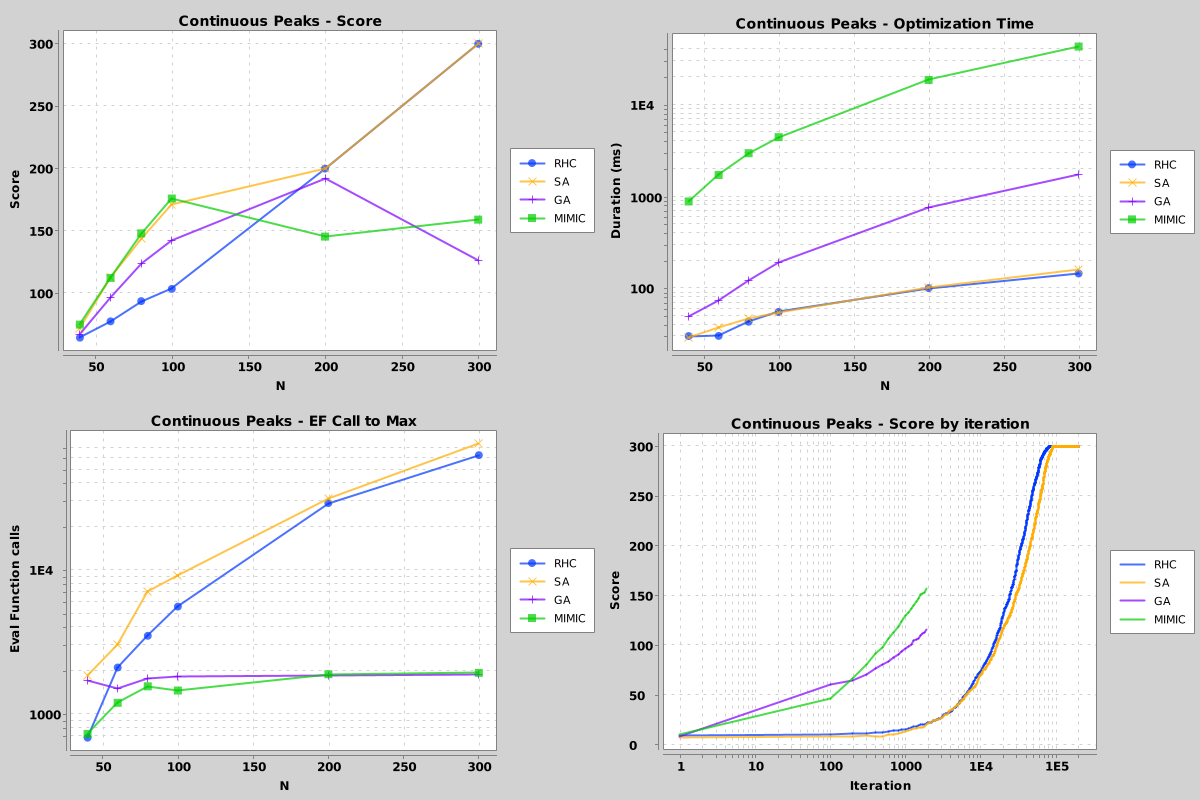

In [47]:
ByteArrayOutputStream outputStream = new ByteArrayOutputStream();
BitmapEncoder.saveBitmap(charts, 2, 2, outputStream, BitmapEncoder.BitmapFormat.PNG);
var input = new ByteArrayInputStream(outputStream.toByteArray());
var image = javax.imageio.ImageIO.read(input);
image;